# Import libraries

In [1]:
import os
import cv2
import imageio
import numpy as np
import matplotlib.pyplot as plt

### Tensorflow dependencies ###
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

### Some constants ###
img_shape     = (112, 112, 3)
latent_dim    = 100
epochs        = 100
batch_size    = 64
learning_rate = 0.000002
beta_1        = 0.5
n_critic      = 3
d_weight_path = 'weights/d.weights.hdf5'
g_weight_path = 'weights/g.weights.hdf5'

# Generator and Critic Architectures

## 1. Generator

In [2]:
def make_generator():
    inputs = Input(shape=(latent_dim, ))
    
    x = Dense(7 * 7 * 16, activation='relu')(inputs)
    x = Reshape(target_shape=(7,7,16))(x)
    
    ### Size now = 14 x 14 x 32 ###
    x = Conv2DTranspose(32, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    ### Size now = 28 x 28 x 64 ###
    x = Conv2DTranspose(64, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    ### Size now = 56 x 56 x 128 ###
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    ### Size now = 112 x 112 x 256 ###
    x = Conv2DTranspose(128, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    
    ### Size now = 112 x 112 x 3 ###
    x = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh', use_bias=False)(x)
    
    model = Model(inputs=inputs, outputs=x, name="Generator")
    return model

G = make_generator()
print(G.summary())

Model: "Generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense (Dense)                (None, 784)               79184     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 32)        8192      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 28, 28, 64)        32

## 2. Discriminator 

In [3]:
def make_discriminator():
    inputs = Input(shape=img_shape)
    
    x = Conv2D(128, kernel_size=4, strides=2, padding='same', use_bias=False)(inputs)
    x = LeakyReLU(alpha=0.2)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(16, kernel_size=4, strides=2, padding='same', use_bias=False)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(1)(x)
    
    model = Model(inputs=inputs, outputs=x, name="Discriminator")
    return model

D = make_discriminator()
print(D.summary())

Model: "Discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 112, 112, 3)]     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 56, 56, 128)       6144      
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 56, 56, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        131072    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 28, 28, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 28, 64)      

# Define loss functions

In [4]:
label_real = tf.ones([batch_size, 1])
label_fake = -tf.ones([batch_size, 1])

def loss_fn(y_true, y_pred):
    return tf.reduce_mean(y_true * y_pred)

def gradient_penalty(sample_real, sample_fake, lambda_=5):    
    with tf.GradientTape() as tape:
        # Get the interpolated image
        epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = sample_fake - sample_real
        interpolated = sample_real + epsilon * diff
        tape.watch(interpolated)

        c_x = D(interpolated, training=True)
        gradients = tape.gradient(c_x, [interpolated])[0]
    
    norm = tf.sqrt(tf.reduce_sum(tf.square(gradients), axis=[1, 2, 3]))
    gp = tf.reduce_mean((norm - 1.0) ** 2)
    
    return gp

# Prepare dataset 

Found 202599 images belonging to 10177 classes.


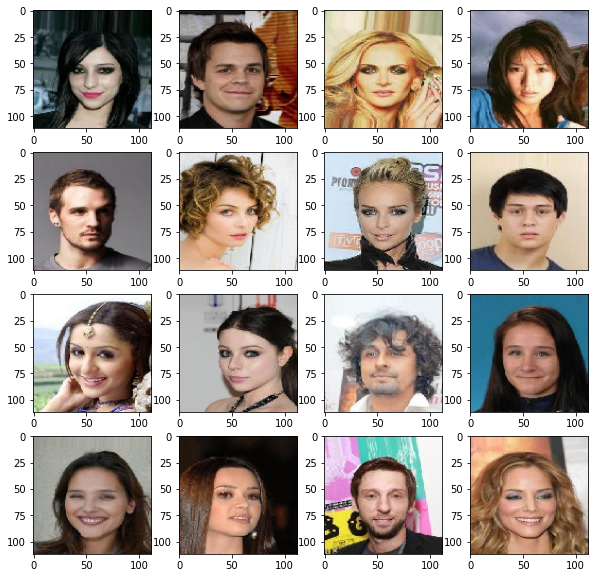

In [5]:
def preprocess(img):
    img = (img - 127.5) / 127.5
    img = img.astype(np.float32)
    
    return img

generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess)
dataset   = generator.flow_from_directory("/home/minhhieu/Desktop/Hieu/datasets/img_align_celeba",
                                         target_size=(img_shape[0], img_shape[1]),
                                         batch_size=batch_size)

dataset_size = len(dataset)

### Visualize sample of data ###
fig, ax = plt.subplots(4,4, figsize=(10, 10))
batchX, batchY = next(dataset)
for i in range(16):
    row = i // 4
    col = i %  4
    
    img = batchX[i] * 127.5 + 127.5
    img = img.astype(np.uint8)
    ax[row][col].imshow(img)

plt.show()

# Training process

## 1. Train step

In [6]:
g_opt = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, decay=0.000005)
d_opt = optimizers.Adam(learning_rate=learning_rate, beta_1=beta_1, decay=0.000005)

def train_step(images):
    '''
        - images : a list of n_critic + 1 batches of real images 
    '''
    for i in range(n_critic):
        with tf.GradientTape() as d_tape:
            noise = tf.random.normal([batch_size, latent_dim])

            gen_images = G(noise, training=True)
            D_fake = D(gen_images, training=True)
            D_real = D(images[i], training=True)

            grad_penalty = gradient_penalty(images[i], gen_images, lambda_=10.0)
            D_loss = tf.reduce_mean(D_fake) - tf.reduce_mean(D_real) + grad_penalty
            # print(D_loss.numpy(), grad_penalty.numpy())

            d_gradient = d_tape.gradient(D_loss, D.trainable_variables)
            d_opt.apply_gradients(zip(d_gradient, D.trainable_variables))
            
    # thetaD = [p.assign(tf.clip_by_value(p, -0.01, 0.01)) for p in D.trainable_variables]
    with tf.GradientTape() as g_tape:
        noise = tf.random.normal([batch_size, latent_dim])
        gen_images = G(noise, training=True)
        D_fake = D(gen_images, training=True)

        # grad_penalty = gradient_penalty(images[n_critic], gen_images)
        G_loss = -tf.reduce_mean(D_fake) # + grad_penalty

        g_gradient = g_tape.gradient(G_loss, G.trainable_variables)
        g_opt.apply_gradients(zip(g_gradient, G.trainable_variables))
        
    return D_loss.numpy(), G_loss.numpy()

## 2. Training loop

In [7]:
# Define the training loop
num_img_to_gen = 16
fixed_latent = tf.random.normal([num_img_to_gen, latent_dim])
grid_size = int(np.sqrt(num_img_to_gen))

def generate_img(latent):
    images = G(latent, training=False).numpy()
    images = ((images * 127.5) + 127.5).astype(np.uint8)

    result = None
    for i in range(grid_size):
        row = None
        for j in range(grid_size):
            index = grid_size * i + j
            if(j == 0):
                row = images[index]
            else:
                row = cv2.hconcat([row, images[index]])
        if(result is None):
            result = row
        else:
            result = cv2.vconcat([result, row])
    
    return result

def generate_gif(images):
    with imageio.get_writer("images/output.gif", mode="I") as writer:
        for i, image in enumerate(images):
            # put frame number
            image = cv2.putText(image, str(i), (10,10), cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0,0,0))
            image = imageio.core.util.Array(image)
            writer.append_data(image)

fixed_latent = tf.random.normal([num_img_to_gen, latent_dim])
def train(dataset):
    images = []
    if(os.path.exists(d_weight_path) and os.path.exists(g_weight_path)):
        print('[INFO] Loading checkpoints ...')
        D.load_weights(d_weight_path)
        G.load_weights(g_weight_path)
        
    for epoch in range(epochs):
        print(f'Epoch #[{epoch}/{epochs}] : ')
        for i in range(dataset_size // (n_critic + 1)):
            batches = []
            for j in range(n_critic+1):
                batchX, batchY = next(dataset)
                batches.append(batchX)
            
            D_loss, G_loss = train_step(batches)
            print(f'Batch #[{i+1}], D loss = {D_loss}, G loss = {G_loss}')
            
            if(((i + 1) % 15) == 0):
                print('    --> Generating gif ... ')
                gen_image = generate_img(fixed_latent)
                images.append(gen_image)
                generate_gif(images)
train(dataset)

[INFO] Loading checkpoints ...
Epoch #[0/100] : 
Batch #[1], D loss = -9.852734565734863, G loss = -1.0097333192825317
Batch #[2], D loss = -10.090899467468262, G loss = -0.8276937007904053
Batch #[3], D loss = -14.362170219421387, G loss = -0.4443719983100891
Batch #[4], D loss = -12.670111656188965, G loss = -0.9520035982131958
Batch #[5], D loss = -11.097898483276367, G loss = -0.8980136513710022
Batch #[6], D loss = -10.93116283416748, G loss = -1.0715503692626953
Batch #[7], D loss = -12.324132919311523, G loss = -0.9498947262763977
Batch #[8], D loss = -11.172759056091309, G loss = -0.8156332969665527
Batch #[9], D loss = -12.544526100158691, G loss = -0.4993787705898285
Batch #[10], D loss = -12.369905471801758, G loss = -0.940849244594574
Batch #[11], D loss = -12.73907470703125, G loss = -0.7611238360404968
Batch #[12], D loss = -12.097131729125977, G loss = -1.1019185781478882
Batch #[13], D loss = -11.614105224609375, G loss = -0.7564166188240051
Batch #[14], D loss = -13.36

KeyboardInterrupt: 

In [ ]:
G.save_weights(g_weight_path)
D.save_weights(d_weight_path)